In [4]:
import pandas as pd
import FitTransform as ft
import HelixFit as hf
import seaborn as sns
import shutil
import numpy as np
import LoopEndpoints as le
import GenerateEndpoints as ge
import util.npose_util as nu
import pickle

import util.npose_util as nu
import os
from pymol import cmd, stored, selector
import util.AA_Exchange as aa

import sys
sys.path.insert(0,f'Clustering/')
import Clustering as cl

import random

Figure 1 Helical Fit

In [2]:
df = pd.read_csv('data/Fits_4H.csv')
df = df.loc[df['name'] != 'name']

for col in df.columns:
    t="float"
    if "length" in col:
        t = "integer"
    elif 'name'  in col:
        continue
    df[col] = pd.to_numeric(df[col],downcast=t)

#remove poor fitting rmsd
df.insert(1, 'max_rmsd', df[df.filter(like='rmsd').columns].max(axis=1))
df = df.loc[df['max_rmsd']<100]

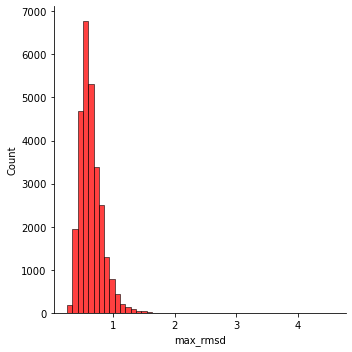

In [3]:
rmsd_dist = sns.displot(df['max_rmsd'], kde=False, color='red', bins=50)
#rmsd_dist.savefig(f'Figures/HelicalFit_Figure/rmsd.svg')

Code to get examples of rmsd levels of the dataset

In [4]:
dfp5_rmsd = df.loc[(df['max_rmsd']>0.49) & (df['max_rmsd']<0.51)]
df1_rmsd = df.loc[(df['max_rmsd']>0.99) & (df['max_rmsd']<1.01)]
nameLocp5 = dfp5_rmsd.columns.get_loc(f'name')
nameLoc1 = df1_rmsd.columns.get_loc(f'name')
fname_rmsdp5 = dfp5_rmsd.iloc[0,nameLocp5]
fname_rmsd1 = df1_rmsd.iloc[0,nameLoc1]
rp5 = hf.HelicalProtein(f'{fname_rmsdp5}.pdb',direc='data/4H_dataset/models')
r1 = hf.HelicalProtein(f'{fname_rmsd1}.pdb',direc=  'data/4H_dataset/models')
rp5.fit_all()
r1.fit_all()

 PyMOL not running, entering library mode (experimental)


In [5]:
#rp5.dump_comparison_poses_(outDirectory='Figures/HelicalFit_Figure/',name='rp5')
#r1.dump_comparison_poses_(outDirectory='Figures/HelicalFit_Figure/',name='r1')
#shutil.copyfile(f'data/bCov_4H_dataset/BCov_Models/{fname_rmsdp5}.pdb',f'Figures/HelicalFit_Figure/rmsdp5_{fname_rmsd1}.pdb')
#shutil.copyfile(f'data/bCov_4H_dataset/BCov_Models/{fname_rmsd1}.pdb',f'Figures/HelicalFit_Figure/rmsd1_{fname_rmsd1}.pdb')

In [ ]:
#r1.dump_endpoints(outDirec='Figures/HelicalFit_Figure/',name=f'ep_{fname_rmsd1}')


Figure 2 GAN


In [23]:
le.bb_analyze("data/BestGenerator",batch=27877,z=12,loopTry=False,print_output=True,analysisOnly=True, outDirec='')

Structures Generation Attempts: 27877
MSE for recon is 0.12 Angstroms
Elapsed time: 724.78
0.03s per structure
No Clash Structures: 8226
Two Atoms or less Clash Structures: 20832
Clashed Atoms Mean: 1.67 +/- 1.30
Percent Core: 0.13 +/- 0.05


In [9]:
le.bb_analyze("data/onePer",batch=27877,z=12,loopTry=False,print_output=True,analysisOnly=True, outDirec='')

Structures Generation Attempts: 27877
MSE for recon is 0.39 Angstroms
Elapsed time: 712.02
0.03s per structure
No Clash Structures: 7384
Two Atoms or less Clash Structures: 18782
Clashed Atoms Mean: 1.85 +/- 1.35
Percent Core: 0.13 +/- 0.06


In [10]:
#make endpoint list of ref dataset

dfRead = pd.read_csv('data/H4_parameters_straight_phi.csv')
df = ft.prepData_Str(dfRead)
dfEnd = ft.EndPoint(df)
npEnd = dfEnd.to_numpy()
epList = npEnd[:,:-5].astype(dtype=np.float32)
epList = epList.reshape((-1,8,3))
np.savez_compressed(f'Figures/GAN_Figure/epGenList.npz',ep=epList)

In [3]:
epR = ge.EP_Recon('Figures/GAN_Figure/epGenList')
print(f'shape of ep list is {epR.endpoints_list.shape}')
npList = epR.to_npose()

shape of ep list is (27877, 8, 3)


In [13]:
#ref dataset calculation for straight helix stats
cc =  []
scn_core = []

for x in range(len(epR.npose_list)):
    cc.append(le.whole_prot_clash_check(epR.npose_list[x],epR.helixLength_list[x]))
    neighs = le.get_neighbor_2D(epR.npose_list[x])
    scn_core.append(le.get_scn(neighs))

cc = np.array(cc)

print(f'No Clash Structures: {len(np.where(cc<1)[0])}')
print(f'Two Atoms or less Clash Structures: {len(np.where(cc<3)[0])}')
print(f'Clashed Atoms Mean: {np.mean(cc):.2f} +/- {np.std(cc):.2f}')
print(f'Percent Core: {np.mean(scn_core):.2f} +/- {np.std(scn_core):.2f}')

No Clash Structures: 8412
Two Atoms or less Clash Structures: 21443
Clashed Atoms Mean: 1.61 +/- 1.26
Percent Core: 0.15 +/- 0.05


In [38]:
#get example of atom clashing structure
indList = np.where(cc>0)[0]
npEnd[1,-1]
pro1 = nu.npose_from_file(f'data/bCov_4H_dataset/BCov_Models/{npEnd[1,-1]}.pdb')
# nu.dump_npdb(pro1,'Figures/GAN_Figure/testpro.pdb')
# nu.dump_npdb(npList[1],'Figures/GAN_Figure/testpro_ep.pdb')

------------- Reference clustering check -----------------------------  
Run and Load alternately since going through to_predict.npz path

In [3]:
#reference clustering for 278 training
#ge.generate_dist_dihe(genName='data/onePer',outName='Figures/GAN_Figure/onePer_dist_dihe',batch_size=27877)
#run to predict via spectral net
#python Clustering.py -i onePer_dist_dihe.npz -n refData -d ../Figures/GAN_Figure/onePer_Clus/ -e -s refData -a data

In [ ]:
#Generate BestGen dataset
#python GenerateEndpoints.py -b 27877 -o Figures/GAN_Figure/data/FullSet_Clus -d -i data/BestGenerator
#python Clustering.py -i FullSet_27877.npz -n refData -d ../Figures/GAN_Figure/FullSet_Clus -e -s refData -a data



In [ ]:
#specNetGPU environ
#python Clustering_SpectralNeuralNet.py -p -i data/refData.npz -n data/sNet #load to predict and save

In [2]:
def prep_for_specNetCluster(name,scaler,inDirec='data',scaler_direc='data'):
    """Applies scaler and saves for loading by spectral net code."""
    chp = cl.ClusterHelixParams(name,direc=inDirec,load_scaler=scaler,scaler_direc=scaler_direc) #scale the new data using the old scaler
    chp.save_for_spectralNet() # save for loading by spectral net, produces to_predict.npz in data/

In [5]:
# #full data
dataDirec = 'Figures/GAN_Figure/FullSet_Clus/'
scaleDirec = 'Clustering/data/'
dataFile = 'FullSet_dist_dihe.npz'

prep_for_specNetCluster(dataFile,'refData',inDirec=dataDirec,scaler_direc=scaleDirec)  

# run in  
# # specNetGPU environ
# # python Clustering_SpectralNeuralNet.py -p -i data/refData.npz -n data/sNet #load to predict and save

In [6]:
# chp = cl.ClusterHelixParams('refData', direc='Clustering/data/', scaler_direc='Clustering/data/',loadCluster=True)
# chp.load_for_spectralNet(direc='Clustering/data/')

array([15,  9,  0, ...,  4,  3,  2])

In [7]:
# np.savez_compressed('Figures/GAN_Figure/FullSet_Clus/FullSet_Clusters.npz',y_train= chp.y_train, y_ = chp.y_)

In [12]:
#one percent data
# dataDirec = 'Figures/GAN_Figure/onePer_Clus/'
# scaleDirec = 'Clustering/data/'
# dataFile = 'onePer_dist_dihe.npz'

# prep_for_specNetCluster(dataFile,'refData',inDirec=dataDirec,scaler_direc=scaleDirec)  

# run in  
# # specNetGPU environ
# # python Clustering_SpectralNeuralNet.py -p -i data/refData.npz -n data/sNet #load to predict and save

In [13]:
# chp = cl.ClusterHelixParams('refData', direc='Clustering/data/', scaler_direc='Clustering/data/',loadCluster=True)
# chp.load_for_spectralNet(direc='Clustering/data/')

In [14]:
#np.savez_compressed('Figures/GAN_Figure/onePer_Clus/onePer_clusters.npz',y_train= chp.y_train, y_ = chp.y_)

In [15]:
# remove Cluster7 data
# dataDirec = 'Figures/GAN_Figure/Remove_Clus7/'
# scaleDirec = 'Clustering/data/'
# dataFile = 'removeClus7_dist_dihe.npz'

# prep_for_specNetCluster(dataFile,'refData',inDirec=dataDirec,scaler_direc=scaleDirec)  

# run in  
# specNetGPU environ
# python Clustering_SpectralNeuralNet.py -p -i data/refData.npz -n data/sNet #load to predict and save

In [16]:
# chp = cl.ClusterHelixParams('refData', direc='Clustering/data/', scaler_direc='Clustering/data/',loadCluster=True)
# chp.load_for_spectralNet(direc='Clustering/data/')

array([13, 16,  0, ...,  5,  9,  2])

In [17]:
# np.savez_compressed('Figures/GAN_Figure/Remove_Clus7/Remove_Clus7_clusters.npz',y_train= chp.y_train, y_ = chp.y_)

In [8]:
dataDirec = 'Figures/GAN_Figure/FullSet_Clus/'
name = 'FullSet_Clusters.npz'



In [9]:
dataDirec = 'Figures/GAN_Figure/Remove_Clus7/'
name = 'Remove_Clus7_clusters.npz'
rr = np.load(f'{dataDirec}{name}', allow_pickle=True)
#Loading data for plotting
r7_y_train, r7_y_ = [rr[f] for f in rr.files]

In [10]:
dataDirec = 'Figures/GAN_Figure/onePer_Clus/'
name = 'onePer_clusters.npz'
rr = np.load(f'{dataDirec}{name}', allow_pickle=True)
#Loading data for plotting
p1_y_train, p1_y_ = [rr[f] for f in rr.files]

In [15]:
chp = cl.ClusterHelixParams('refData', direc='Clustering/data/', scaler_direc='Clustering/data/',loadCluster=True)

In [16]:
chp.y_

array([ 8,  6,  0, ..., 22,  5,  5])

In [17]:
co = ['Generator 27877', 'Generator 278', 'RemoveCluster_7', 'Reference Set']
npClus = np.vstack((full_y_.reshape(-1,1),p1_y_.reshape(-1,1), r7_y_.reshape(-1,1), chp.y_.reshape(-1,1))).squeeze()
typeArray = np.expand_dims(np.array(co,dtype=object),axis=0).repeat(full_y_.shape[0])

In [18]:
npClus.shape

(111508,)

In [23]:
typeArray.shape[0]/27877

4.0

In [20]:
df1 = pd.DataFrame(np.hstack((npClus.reshape(-1,1),typeArray.reshape(-1,1))),columns=['Cluster Number','Type'])

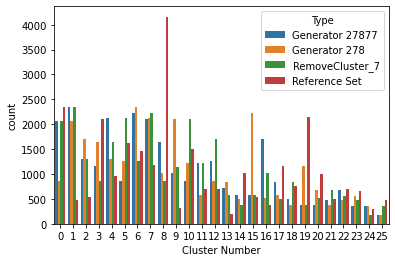

In [21]:
ax = sns.countplot(data=df1, hue='Type',x='Cluster Number')

In [24]:
for x in range(26):
    print(sum(full_y_==x))
    print(sum(chp.y_==x))
    print(sum(r7_y_==x))

2056
2345
2056
2345
472
2345
1302
536
1302
1152
2105
850
2118
955
1647
857
1625
2116
2217
1454
1269
2104
1190
2217
1647
4160
857
1023
321
1151
850
1495
2104
1223
700
1224
1270
708
1702
723
187
571
576
1024
372
571
531
576
1702
373
1024
845
1162
507
507
761
845
370
2155
382
382
992
515
473
503
677
677
696
563
364
663
473
355
289
168
168
475
364


In [56]:
sum(chp.y_==1)

2055

In [26]:
#this loads the compare clusters and then uses the numbers in the reference clusters to match clusters

gen_278 = chp.loc[chp['type']=='generated'].to_numpy()
ref_278 = chp.loc[chp['type']=='reference'].to_numpy()

gen_full = chp_full.loc[chp['type']=='generated'].to_numpy()
ref_full = chp_full.loc[chp['type']=='reference'].to_numpy()

index_278 = ref_278[:, 1].argsort()
index_Full = ref_full[:,1].argsort()

gen_full_norm = gen_full[index_Full][:,2]
ref = ref_full[index_Full][:,2]
gen_278_norm = gen_278[index_278][:,2]

In [23]:
?np.argsort

Plot all three clustered sets together

In [139]:
co = ['Generator 27877', 'Generator 278', 'Reference Set']
npClus = np.vstack((gen_full_norm.reshape(-1,1),gen_278_norm.reshape(-1,1), ref.reshape(-1,1)))

typeArray = np.array(['Generator 27877']*ref.shape[0],dtype=object).reshape((-1,1))
typeArray = np.vstack((typeArray,np.array(['Generator 278']*ref.shape[0],dtype=object).reshape((-1,1))))
typeArray = np.vstack((typeArray,np.array(['Reference Set']*ref.shape[0],dtype=object).reshape((-1,1)))).squeeze()



cn= np.vstack((np.array(range(ref.shape[0])).reshape((-1,1)),np.array(range(ref.shape[0])).reshape((-1,1)),np.array(range(ref.shape[0])).reshape((-1,1)))).squeeze()

dataComb = np.hstack((cn.reshape((-1,1)),npClus,typeArray.reshape((-1,1))))
df = pd.DataFrame(dataComb,columns=['Cluster Number','Amount','Type'])
df

,Cluster Number,Amount,Type
0,0,228,Generator 27877
1,1,442,Generator 27877
2,2,368,Generator 27877
3,3,583,Generator 27877
4,4,367,Generator 27877
...,...,...,...
73,21,1632,Reference Set
74,22,2103,Reference Set
75,23,2149,Reference Set
76,24,2349,Reference Set


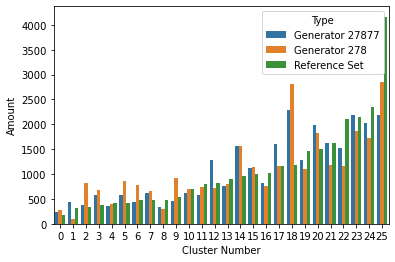

In [141]:
ax = sns.barplot(data=df, hue='Type',x='Cluster Number',y='Amount')

In [144]:
ax.figure.savefig('Figures/GAN_Figure/ClusterCheck_Generation.svg')

Figure 3 Looping Endpoints

In [5]:
#Looped Endpoints example line
le.bb_analyze("data/BestGenerator",batch=16,z=12,loopTry=True,print_output=False,analysisOnly=False, outDirec='output/')

Structures Generation Attempts: 16
MSE for recon is 0.12 Angstroms
Elapsed time: 0.46
0.03s per structure
No Clash Structures: 7
Two Atoms or less Clash Structures: 12
Clashed Atoms Mean: 1.38 +/- 1.36
Percent Core: 0.13 +/- 0.06
Loop Success: 16. Phi Reduced Structures: 199
Total time: 11.63
Time Per Unique Topology: 0.73s
Time Per Phi Bins Struct: 0.06s


In [2]:
#create example of helix_loop_helix for the loop fitting part of loop endpoints
#this first method is defunct.
prot1 = le.loop_fit_protein(0)
nu.dump_npdb(prot1,'Figures/Loop_Figure/exampleLoop.pdb')
l2 = hf.HelicalProtein('exampleLoop.pdb',direc='Figures/Loop_Figure/',expected_helices=2)
l2.fit_all()
l2.dump_endpoints(name='exampleEP',outDirec='Figures/Loop_Figure/')

In [3]:
#load epList
rr = np.load(f'Figures/GAN_Figure/epGenList.npz')
epList = [rr[f] for f in rr.files][0]

In [13]:
#example to make e_true and e_guide, changed and now defunct
# ep_guide = epList[:8]
# #guide/ true endpoint example
# n1=100 
# neighbors=10
# dist_cut=5
# phiQueryNum=10
# maxTot=5000
# maxTotN1=5000
# randMult=10

# size = 8
# build = le.stub.copy()
# #ep_guide = end_points.copy()
    
    
# build, extlength = le.first_helix(ep_guide[0]) #create first helix based on length of first/second endpoints
# buildList, eguide, etrue, indexTot, clashTot, distTot = le.first_loop_second_helix_phi_rand(build, extlength, ep_guide[0], neighbors=n1,size=size,
#                                                       dist_cut=dist_cut, maxTot=maxTotN1, phiQueryNum=phiQueryNum, debug=True, randMult=randMult)
# hf.HelicalProtein.makePointPDB(etrue[0][0][:4],'ep_true.pdb',outDirec='Figures/Loop_Figure/guide_true/')
# hf.HelicalProtein.makePointPDB(eguide[0][0],'ep_guide.pdb',outDirec='Figures/Loop_Figure/guide_true/')
# nu.dump_npdb(buildList[0][0],'Figures/Loop_Figure/guide_true/t_build.pdb')

In [5]:
oD = 'Figures/Loop_Figure/output/reference_1028/'

In [22]:
#random 1028 from epList to compare to generator
indexer = np.random.choice(range(epList.shape[0]),1028 ,replace=False)
np.savez_compressed(f'Figures/Loop_Figure/epList_rand1028.npz',ep=epList[indexer])

In [6]:
#reference endpoints
le.bb_loop(f'Figures/Loop_Figure/epList_rand1028',z=12,loopTry=True,print_output=False,analysisOnly=False, outDirec=oD)

Num Endpoints: 1028
No Clash Structures: 314
2 or less atoms clashes: 789
Clashed Atoms Mean: 1.61 +/- 1.27
Percent Core: 0.15 +/- 0.05
Loop Success: 1020. Total Phi Bins Generated: 12407
Total time: 686.89
Time Per Unique Topology: 0.67s
Time Per Phi Bins Struct: 0.06s


In [7]:
oD = 'Figures/Loop_Figure/output/Full_1028/'

le.bb_analyze("data/BestGenerator",batch=1028,outDirec=oD,analysisOnly=False,loopTry=True,print_output=False)

Structures Generation Attempts: 1028
MSE for recon is 0.13 Angstroms
Elapsed time: 25.62
0.02s per structure
No Clash Structures: 292
Two Atoms or less Clash Structures: 767
Clashed Atoms Mean: 1.71 +/- 1.30
Percent Core: 0.13 +/- 0.05
Loop Success: 1015. Phi Reduced Structures: 12303
Total time: 902.05
Time Per Unique Topology: 0.89s
Time Per Phi Bins Struct: 0.07s


In [8]:
oD = 'Figures/Loop_Figure/output/onePer_1028/'

le.bb_analyze("data/onePer",batch=1028,outDirec=oD,analysisOnly=False,loopTry=True,print_output=False)

Structures Generation Attempts: 1028
MSE for recon is 0.38 Angstroms
Elapsed time: 25.90
0.03s per structure
No Clash Structures: 289
Two Atoms or less Clash Structures: 706
Clashed Atoms Mean: 1.79 +/- 1.35
Percent Core: 0.12 +/- 0.06
Loop Success: 1010. Phi Reduced Structures: 11830
Total time: 1090.67
Time Per Unique Topology: 1.08s
Time Per Phi Bins Struct: 0.09s


Generation of Looped Protein for Design Test

In [184]:
oD = 'Figures/DesignTest/full_Looped_b512/'

le.bb_analyze("data/BestGenerator",batch=512,outDirec=oD,analysisOnly=False,loopTry=True,print_output=False)

Structures Generation Attempts: 512
MSE for recon is 0.12 Angstroms
Elapsed time: 13.36
0.03s per structure
No Clash Structures: 134
Two Atoms or less Clash Structures: 357
Clashed Atoms Mean: 1.80 +/- 1.32
Percent Core: 0.13 +/- 0.05
Loop Success: 503. Phi Reduced Structures: 6040
Total time: 452.13
Time Per Unique Topology: 0.90s
Time Per Phi Bins Struct: 0.07s


In [185]:
oD = 'Figures/DesignTest/onePer_Looped_b512/'

le.bb_analyze("data/onePer",batch=512,outDirec=oD,analysisOnly=False,loopTry=True,print_output=False)

Structures Generation Attempts: 512
MSE for recon is 0.37 Angstroms
Elapsed time: 13.63
0.03s per structure
No Clash Structures: 147
Two Atoms or less Clash Structures: 363
Clashed Atoms Mean: 1.75 +/- 1.33
Percent Core: 0.12 +/- 0.06
Loop Success: 503. Phi Reduced Structures: 5927
Total time: 635.82
Time Per Unique Topology: 1.26s
Time Per Phi Bins Struct: 0.11s


For the GraphGen Series  
This  First Section is defunct low correlation between score and number of missing rotamers, could investigate more 

In [124]:
#----------------predict_relax------------
modelDirec = 'data/4H_dataset/models/'
straightDirec = 'data/4H_dataset/str_models/'

In [130]:
direc_in = 'Figures/GraphGen_Figure/output/ref_relax_test/'
fL = os.listdir(direc_in)

In [131]:
direc = 'Figures/GraphGen_Figure/rmd_calc/'
ref = f'reference'
ref_rel = 'refseq_relax'

In [103]:
def get_seq_pymol(direcName=direc):
    """record actual sequence from designed protein"""

    cmd.delete("all")
    cmd.load(f'{direc}{ref}.pdb')

    #get sequence per Atom
    stored.resn = []
    cmd.iterate_state(1, selector.process(f"{ref} and *"), "stored.resn.append(resn)")
    seqa = ''
    for x in stored.resn:
        seqa = f'{seqa}{aa.aaCodeExchange(x)}'
        
    #get sequence
    stored.resn = []
    cmd.iterate_state(1, selector.process(f"{ref} and n. CA"), "stored.resn.append(resn)")
    seq = ''
    for x in stored.resn:
        seq = f'{seq}{aa.aaCodeExchange(x)}'

    return seqa, seq

def get_index(seq,arr=['A','I','L','V','F','M']):
    
    indexArray = []
    
    for x in range(len(seq)):
        if seq[x] in arr:
            indexArray.append(x)
            
    return indexArray


In [104]:
def rmsd_calc_refRelax(direcName=direc):
    seq_all_atom, seq = get_seq_pymol()
    
    cmd.delete("all")
    cmd.load(f'{direcName}{ref}.pdb')
    ref_all = cmd.get_coords(f"{ref}", 1)
    ref_ca = cmd.get_coords(f"{ref}  and n. CA", 1)
    
    cmd.delete("all")
    cmd.load(f'{direcName}{ref_rel}.pdb')
    ref_relax_all = cmd.get_coords(f"{ref_rel}", 1)
    ref_relax_ca = cmd.get_coords(f"{ref_rel}  and n. CA", 1)
    
    #index just the hydrophobics
    diff_ca = ref_ca - ref_relax_ca
    diff_all = ref_all - ref_relax_all
    
    d_ca = np.linalg.norm(diff_ca,axis=1)
    d_all = np.linalg.norm(diff_all,axis=1)
    
    return d_ca, d_all
    

In [117]:
def perAA_msd(direcName=direc):
    seq_all_atom, seq = get_seq_pymol()
    
    ref_aa = []
    ref_rel_aa = []
    
    cmd.delete("all")
    cmd.load(f'{direcName}{ref}.pdb')
    
    for x in range(len(seq)):
        aaXYZ = cmd.get_coords(f'{ref}  and resi {x+1}', 1)
        ref_aa.append(aaXYZ)
        
    cmd.delete("all")
    cmd.load(f'{direcName}{ref_rel}.pdb')
    
    for x in range(len(seq)):
        aaXYZ = cmd.get_coords(f'{ref_rel}  and resi {x+1}', 1)
        ref_rel_aa.append(aaXYZ)
    
    max_msd_aa = []
    
    for x in range(len(seq)):
        max_msd_aa.append(np.max(np.linalg.norm(ref_aa[x] - ref_rel_aa[x],axis=1)))

    
    return np.array(max_msd_aa)
        
    
    

In [136]:
rotamer_change = []
limit = 10
counter = 0

msd_aa_hydro = []
d_ca_hydro = []

for x in fL:
    name = x[:-13]
    name_rel = x[:-4]
    cmd.delete("all")
    cmd.load(f'{modelDirec}{name}.pdb')
    cmd.load(f'{direc_in}{name_rel}.pdb')
    cmd.super(name, name_rel)
    cmd.save(f'{direc}{ref}.pdb', selection=name)
    cmd.save(f'{direc}{ref_rel}.pdb', selection=name_rel)
    seq_all_atom, seq = get_seq_pymol()
    ind_all = np.array(get_index(seq_all_atom)) #returns indices of AIFLV AA's
    ind = np.array(get_index(seq))
    
    msd_aa = perAA_msd()
    d_ca, d_all = rmsd_calc_refRelax()
    
    msd_aa = msd_aa[ind]
    d_ca = d_ca[ind]
    
    rotamer_change.append([name,sum(msd_aa>1.5)])
    
    msd_aa_hydro.append(msd_aa)
    d_ca_hydro.append(d_ca)

In [172]:
df_rmsd = np.hstack((rotamer_change,np.array(msd_aa_hydro).reshape(-1,1),np.array(d_ca_hydro).reshape(-1,1)))
df_rmsd = pd.DataFrame(df_rmsd,columns=['name','RotWrong','msd_aa','ca_msd'])

<ipython-input-172-446b425ba99b>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_rmsd = np.hstack((rotamer_change,np.array(msd_aa_hydro).reshape(-1,1),np.array(d_ca_hydro).reshape(-1,1)))


In [173]:
df_rmsd.head()

,name,RotWrong,msd_aa,ca_msd
0,0002182ba9e87d7b0d6b7d16b7001923_0001,3,"[0.6295118, 0.69549274, 0.6353631, 0.45776635,...","[0.4940537, 0.369332, 0.23803343, 0.279782, 0...."
1,000877380acb95e21726d9df052ec962_0001,3,"[0.5692838, 0.27968004, 0.4156457, 3.4844878, ...","[0.2787364, 0.18250757, 0.29595578, 0.51076984..."
2,0009c3faef123ed29e447cf47337d656_0001_1,4,"[0.2720643, 0.49752465, 0.71007186, 4.5127707,...","[0.2379771, 0.42500806, 0.29450598, 0.59163684..."
3,000b40b97b3761973c100b7325f5bf41_0001_1,5,"[3.9889429, 0.69999224, 0.4738529, 1.1594276, ...","[0.3522059, 0.43206617, 0.30024657, 0.5210696,..."
4,001126bfe8b2f13d0bd52996ae0b77e8_0001_1,5,"[0.73133504, 5.0132637, 0.8628743, 0.50977856,...","[0.6071459, 0.64689183, 0.48766473, 0.28169495..."


In [179]:
df_rotGraph.head()

,name,RotWrong,msd_aa,ca_msd,seq,spr,time,Name
0,0002182ba9e87d7b0d6b7d16b7001923_0001,3,"[0.6295118, 0.69549274, 0.6353631, 0.45776635,...","[0.4940537, 0.369332, 0.23803343, 0.279782, 0....",MIEELLEKALARNASEELLKKAAEKIEEHKKAKSKEYEKALKLLEE...,-2.241017,21.385715,gg_orig
1,0002182ba9e87d7b0d6b7d16b7001923_0001,3,"[0.6295118, 0.69549274, 0.6353631, 0.45776635,...","[0.4940537, 0.369332, 0.23803343, 0.279782, 0....",SLEELLEEARKLGVPPELLERVEELLKELEERGDPRREEVRRLLEE...,-2.394907,31.892265,gg_new
2,0002182ba9e87d7b0d6b7d16b7001923_0001,3,"[0.6295118, 0.69549274, 0.6353631, 0.45776635,...","[0.4940537, 0.369332, 0.23803343, 0.279782, 0....",SLDEILETLKELGVPPELLEEVKKVLEELERRGDPKREEVRRLLEE...,-2.643990,37.128287,ref_relax
3,000877380acb95e21726d9df052ec962_0001,3,"[0.5692838, 0.27968004, 0.4156457, 3.4844878, ...","[0.2787364, 0.18250757, 0.29595578, 0.51076984...",SMALEKLKEAMAAKDVEALAAECAALAAARAAGSAEAAAAAAALAA...,-1.887903,10.228325,gg_orig
4,000877380acb95e21726d9df052ec962_0001,3,"[0.5692838, 0.27968004, 0.4156457, 3.4844878, ...","[0.2787364, 0.18250757, 0.29595578, 0.51076984...",DELEEELRRALEEGDEELLRRILEEIVRLLKEGDPRAKKVLEKLEE...,-2.668185,20.834725,gg_new


In [178]:
df_rotGraph = pd.merge(df_rmsd, df_tot, on=['name'])

<AxesSubplot:xlabel='RotWrong', ylabel='spr'>

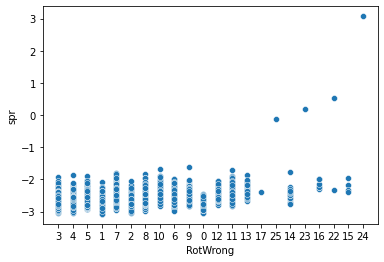

In [182]:
sns.scatterplot(data=df_rotGraph.loc[df_rotGraph['Name']=='ref_relax'], x='RotWrong', y='spr')

In [167]:
np.array(msd_aa_hydro).shape

<ipython-input-167-bda9b283e37b>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(msd_aa_hydro).shape


(8431,)

GraphGen Stats Data - actually used

In [6]:
def openArray(name,direc='Figures/GraphGen_Figure/output/'):
    
    with open(f'{direc}/{name}_nameList.pkl', 'rb') as f:
        nameList = pickle.load(f)
    with open(f'{direc}/{name}_scoreList.pkl', 'rb') as f:
        scoreList = pickle.load(f)
        
    return nameList, scoreList
def extract_spr(scoresList):
    
    outList = []
    #get total score and normalize to sequence length, final score needs associated sequence in different array place
    for x in scoresList:
        inner = []
        for y in range(len(x)):
            if y == 2:
                inner.append(x[y]['total_score']/len(x[1])) #score/res
            else:  
                inner.append(x[y])
        outList.append(inner)
        
    return outList

def buildNum_Column(nameList):
    buildNum_List = []
    for x in nameList:
        buildNum_List.append(int(x.split('_')[0][5:]))
        
    return buildNum_List
        

In [7]:
cols =['name','seq','spr','time']

nL1, sL = openArray('refRelax')
sL_ref_relax = extract_spr(sL)


df_r = pd.DataFrame(sL_ref_relax,columns=cols)
df_r['Name']='ref_relax'

nL2, sL = openArray('gg_orig')
sL_gg_orig = extract_spr(sL)


df_o = pd.DataFrame(sL_gg_orig,columns=cols)
df_o['Name']='gg_orig'

nL3, sL = openArray('gg_new')
sL_gg_new = extract_spr(sL)

df_g = pd.DataFrame(sL_gg_new,columns=cols)
df_g['Name']='gg_new'

In [8]:
spr ='spr'

In [9]:
spr ='spr'
print(f'score per res median for new graph gen is : {df_g[spr].median():.2f}')
print(f'score per res median for original graph gen is : {df_o[spr].median():.2f}')
print(f'score per res median for reference graph gen is : {df_r[spr].median():.2f}')

score per res median for new graph gen is : -2.55
score per res median for original graph gen is : -2.04
score per res median for reference graph gen is : -2.64


In [10]:
spr ='time'
print(f'average design time for new graph gen is : {df_g[spr].mean():.2f}s')
print(f'average design time for original graph gen is : {df_o[spr].mean():.2f}s')
print(f'average design time for reference graph gen is : {df_r[spr].mean():.2f}s')

average design time for new graph gen is : 14.64s
average design time for original graph gen is : 12.16s
average design time for reference graph gen is : 15.31s


In [11]:
#pull s
def openArray_ref(direc):
    
    with open(f'{direc}nameList.pkl', 'rb') as f:
        nameList = pickle.load(f)
    with open(f'{direc}scoreList.pkl', 'rb') as f:
        scoreList = pickle.load(f)
        
    return nameList, scoreList
def make_dict_ref(nameList,scoreList,removeExt=False):
    
    s = dict()
    
    for x in range(len(nameList)):
        if removeExt:
            name = nameList[x][:-4]
        else:
            name = nameList[x]
        s[name] = scoreList[x][2]['total_score']/len(scoreList[x][1])
        
    return s

nLr, sLr = openArray_ref(direc=f'Figures/GraphGen_Figure/output/ref_')
ref_dict = make_dict_ref(nLr,sLr,removeExt=False)
    

In [12]:
df_rr = df_r.copy()
df_rr['time']= np.NAN
df_rr['Name']='ref_set'
df_rr['spr']=df_rr['name'].map(ref_dict)

In [13]:
df_rr

,name,seq,spr,time,Name
0,0002182ba9e87d7b0d6b7d16b7001923_0001,SLDEILETLKELGVPPELLEEVKKVLEELERRGDPKREEVRRLLEE...,-2.894166,NaN,ref_set
1,000877380acb95e21726d9df052ec962_0001,DELEERVREALERGDPELLRKILRELVELLKKGDPEARKVLEILEE...,-2.807201,NaN,ref_set
2,0009c3faef123ed29e447cf47337d656_0001_1,SEDVEETAKELLERGTVEEFLKELKEELKERGDPELEKLLEKAEEL...,-2.799184,NaN,ref_set
3,000b40b97b3761973c100b7325f5bf41_0001_1,PEEEELKRLAKELGNPELAKLIELLLELLKQGDPDAEEALRLVKEL...,-2.772415,NaN,ref_set
4,001126bfe8b2f13d0bd52996ae0b77e8_0001_1,SDEELIEEIVEKLGLPPELREVARLIIELVKKGVPPEEVKELAKKL...,-2.904153,NaN,ref_set
...,...,...,...,...,...
11551,fff4e785597a4ff34da351291ce419a0_0001,SELEERIEEAIRRGDKDLFERLIRELIKRLKEGDPEAEEILRRVEE...,-2.798456,NaN,ref_set
11552,fff532a1f3bd52993b00d58dc306e14c_0001_1,SLRELAKEIRRTFPPEEVVELLLELARELGDPEVVRVAEELLERLR...,-2.860219,NaN,ref_set
11553,fff8daf3a52878a3bf78d4aa4fd68612_0001_1,SIEELLELIKRLLPPELRERVERIIEEAKRLAGGDPELAEELFEKL...,-2.769021,NaN,ref_set
11554,fffaaf5372bf5d4f67462faa60fe4466_0001,GPEEREEIRKLLERLPPEEVKKLIEKIAKELGLPPEEIEKLKELVE...,-2.908331,NaN,ref_set


In [14]:
df_tot = pd.concat([df_o,df_g,df_r])

In [15]:
df_tot2 = pd.concat([df_o,df_r])

In [16]:
df_tot3 = pd.concat([df_r,df_rr])

In [17]:
df_tot.head()

,name,seq,spr,time,Name
0,0002182ba9e87d7b0d6b7d16b7001923_0001,MIEELLEKALARNASEELLKKAAEKIEEHKKAKSKEYEKALKLLEE...,-2.241017,21.385715,gg_orig
1,000877380acb95e21726d9df052ec962_0001,SMALEKLKEAMAAKDVEALAAECAALAAARAAGSAEAAAAAAALAA...,-1.887903,10.228325,gg_orig
2,0009c3faef123ed29e447cf47337d656_0001_1,MEEALEEARRLAEARDAAAAFAAARARAREARREAAEAAAAAAEAA...,-1.891431,10.653046,gg_orig
3,000b40b97b3761973c100b7325f5bf41_0001_1,MLAEEAIAAAKRAKEAAAAERVRAAAAAVERRAAAAAAALAAFLEH...,-1.736683,7.140037,gg_orig
4,001126bfe8b2f13d0bd52996ae0b77e8_0001_1,MLEEKAKAIAEELNSDENHVKLALKAMECLLSNEDIEKCLEKAKEE...,-2.295954,29.900236,gg_orig


In [44]:
hex_col = ["f1ed36", "#C2CD23", "43a8e4"]
color_codes_wanted = ['yellow', 'green', 'purple']


ValueError: Invalid RGBA argument: '43a8e4'

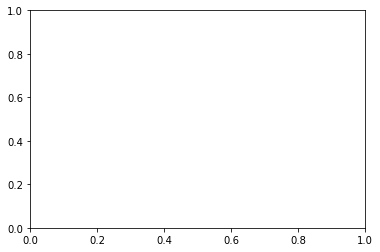

In [45]:
f1 = sns.histplot(data=df_tot,x='spr',hue='Name',binrange=((-3.5,-1)),palette = hex_col)
f1.figure.savefig('Figures/GraphGen_Figure/hisplot_og.png')

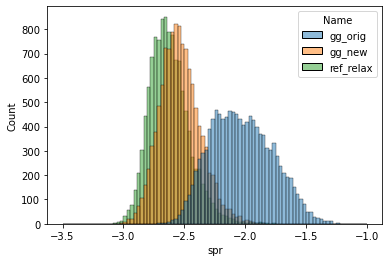

In [43]:
f1 = sns.histplot(data=df_tot,x='spr',hue='Name',binrange=((-3.5,-1)))
f1.figure.savefig('Figures/GraphGen_Figure/hisplot_gg_full.png')

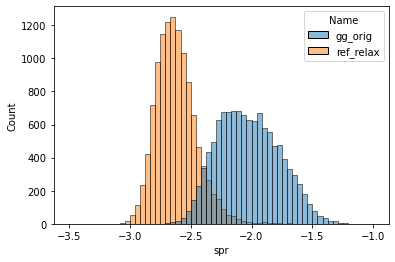

In [33]:
df_tot1 = pd.concat([df_o,df_r])
f2 = sns.histplot(data=df_tot1,x='spr',hue='Name',binrange=((-3.5,-1)))
f2.figure.savefig('Figures/GraphGen_Figure/hisplot_og.png')

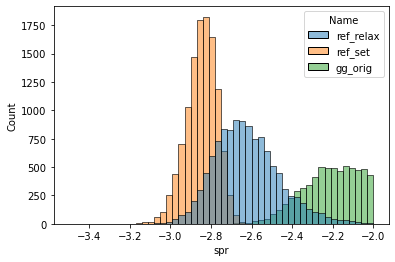

In [34]:
df_tot3 = pd.concat([df_r,df_rr,df_o])
f3 = sns.histplot(data=df_tot3,x='spr',hue='Name',binrange=((-3.5,-2)), bins=50)
f3.figure.savefig('Figures/GraphGen_Figure/ref_hisplot.png')

In [ ]:
df_tot1 = pd.concat([df_o,df_r])
f4 = sns.histplot(data=df_tot1,x='spr',hue='Name',binrange=((-3.5,-1)))
f4.figure.savefig('Figures/GraphGen_Figure/hisplot_ref4.png')

In [15]:
#----design test

In [27]:
cols =['name','seq','spr','time','b_num']

nL, sL = openArray('gg_new',direc='Figures/DesignTest/')
sL_Full= extract_spr(sL)
bL = np.array(buildNum_Column(nL))

sL_Full = np.hstack((sL_Full,bL.reshape(-1,1)))

df_f = pd.DataFrame(sL_Full,columns=cols)
df_f['b_num'] = df_f['b_num'].astype('int32')
df_f['spr'] = df_f['spr'].astype('float32')
df_f['time']=df_f['time'].astype('float32')
df_f['Name']='Full'

nL_1, sL_1 = openArray('gg_new_onePer',direc='Figures/DesignTest/')
sL_op= extract_spr(sL_1)

bL1 = np.array(buildNum_Column(nL_1))
sL_op = np.hstack((sL_op,bL1.reshape(-1,1)))

df_1 = pd.DataFrame(sL_op,columns=cols)
df_1['b_num'] = df_f['b_num'].astype('int32')
df_1['spr'] = df_1['spr'].astype('float32')
df_1['time']=df_1['time'].astype('float32')
df_1['Name']='onePer'

In [28]:
df_f['time'].sum()/504

159.34623015873015

In [35]:
df_1['time'].sum()/494

162.9971691548583

In [114]:
df_tot = pd.concat([df_f,df_1,df_r])

<AxesSubplot:xlabel='spr', ylabel='Density'>

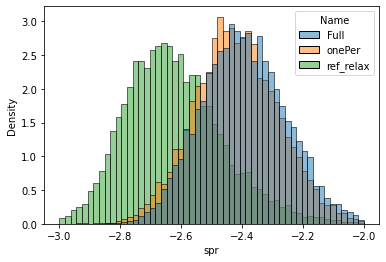

In [115]:
sns.histplot(data=df_tot,x='spr',hue='Name',stat="density", common_norm=False,binrange=(-3,-2))
#f1.figure.savefig('Figures/DesignTest/Design_All.png')

In [77]:
df_f['spr'].mean()

-2.393346

In [90]:
df_r['spr'].median()

-2.6382395820583557

In [14]:
#bL =np.empty((1,1))
bL1 = []
bLf = []

for x in range(512):
    minVal_f = df_f.loc[df_f['b_num']==x]['spr'].min()
    minVal_1 = df_1.loc[df_1['b_num']==x]['spr'].min()
    
    bL1.append([minVal_1])
    bLf.append([minVal_f])
    
    #bL = np.vstack((bL,np.array([minVal]*numBuild).reshape(-1,1)))
        

In [15]:
bL1 = np.array(bL1)
bLf = np.array(bLf)
bL1 = bL1[~np.isnan(bL1)]
bLf = bLf[~np.isnan(bLf)]
bL_r = df_r['spr'].to_numpy()

In [16]:
df_1 = pd.DataFrame(bL1,columns=['spr'])
df_1['Name'] = 'One Percent'
df_f = pd.DataFrame(bLf,columns=['spr'])
df_f['Name'] = 'Full'
df_r = pd.DataFrame(bL_r,columns=['spr'])
df_r['Name'] = 'Reference Relax'

In [17]:
df_1['spr'].median()
df_f['spr'].median()

-2.6060791015625

In [21]:
df_1.shape[0]

494

In [22]:
df_f.shape[0]

503

In [ ]:
df_f.

In [83]:
df_tot = pd.concat([df_f,df_1,df_r])

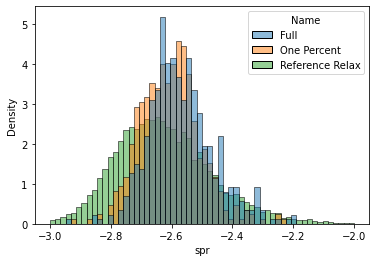

In [85]:
f1=sns.histplot(data=df_tot,x='spr',hue='Name', stat="density", common_norm=False,binrange=(-3,-2))

In [86]:
#f1.figure.savefig('Figures/DesignTest/Norm_Design.png')